In [2]:
import pandas as pd
import plotly.express as px
import scipy.stats as stats
import geopandas as gpd
from shapely.geometry import Point
import statsmodels.api as sm
from statsmodels.formula.api import ols
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt

/Users/tinas/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
print("tina")

tina


In [4]:
data = pd.read_csv("../data/landing/alt_properties.csv")

In [5]:
data.head(5)

URL  \
0  https://www.domain.com.au/304-373-377-burwood-...   
1  https://www.domain.com.au/17-brooks-street-faw...   
2  https://www.domain.com.au/37-genesis-drive-epp...   
3  https://www.domain.com.au/1-30-park-street-moo...   
4  https://www.domain.com.au/343-dromana-parade-s...   

                   Rent_Price                                        Address  \
0        <span>$580.00</span>  304/373-377 Burwood Highway, Burwood VIC 3125   
1  <span>$590 per week</span>             17 Brooks Street, Fawkner VIC 3060   
2  <span>$580 PER WEEK</span>              37 Genesis Drive, Epping VIC 3076   
3        <span>$575.00</span>        1/30 Park Street, Moonee Ponds VIC 3039   
4  <span>$850 Per Week</span>      343 Dromana Parade, Safety Beach VIC 3936   

  Bedrooms Bathrooms Parking            Property_Type   Latitude   Longitude  \
0        2         2       1  Apartment / Unit / Flat -37.851369  145.129537   
1        4         1       2                    House -37.706151  144.972919   
2        3         2       1                    House -37.622732  144.999599   
3        2         1       2  Apartment / Unit / Flat -37.761711  144.918994   
4        4         3       2                    House -38.308161  144.995930   

               Property_Headline  \
0        Convenience and Comfort   
1              HOME SWEET HOME!!   
2        Convenient Family Home!   
3           Park Street Prestige   
4  Location, location, location!   

                                Property_Description  
0  This extremely stylish two-bedroom apartment i...  
1  Welcome to 17 Brooks Street in the charming su...  
2  TO APPLY: please click "Get in touch" or "Enqu...  
3  ** BOOK INSPECTION ONLINE OR SAVE TIME VIEW OU...  
4  This stunning beachside double-story residence...

## Cleaning & Preprocess

In [6]:
data['Rent_Price'] = (
    data['Rent_Price']
    .replace(',', '', regex=True)  
    .str.extract(r'\$\s*([\d,]+\.\d+|\d+)')[0]
    .fillna(0) 
    .astype(float)  
)


In [7]:

data[['Street', 'Suburb', 'Postcode']] = data['Address'].str.extract(
    r'^(?:(.*?),\s*)?([A-Za-z\s]+)\s+VIC\s+(\d+)$', expand=True)


data.head(5)

URL  Rent_Price  \
0  https://www.domain.com.au/304-373-377-burwood-...       580.0   
1  https://www.domain.com.au/17-brooks-street-faw...       590.0   
2  https://www.domain.com.au/37-genesis-drive-epp...       580.0   
3  https://www.domain.com.au/1-30-park-street-moo...       575.0   
4  https://www.domain.com.au/343-dromana-parade-s...       850.0   

                                         Address Bedrooms Bathrooms Parking  \
0  304/373-377 Burwood Highway, Burwood VIC 3125        2         2       1   
1             17 Brooks Street, Fawkner VIC 3060        4         1       2   
2              37 Genesis Drive, Epping VIC 3076        3         2       1   
3        1/30 Park Street, Moonee Ponds VIC 3039        2         1       2   
4      343 Dromana Parade, Safety Beach VIC 3936        4         3       2   

             Property_Type   Latitude   Longitude  \
0  Apartment / Unit / Flat -37.851369  145.129537   
1                    House -37.706151  144.972919   
2                    House -37.622732  144.999599   
3  Apartment / Unit / Flat -37.761711  144.918994   
4                    House -38.308161  144.995930   

               Property_Headline  \
0        Convenience and Comfort   
1              HOME SWEET HOME!!   
2        Convenient Family Home!   
3           Park Street Prestige   
4  Location, location, location!   

                                Property_Description  \
0  This extremely stylish two-bedroom apartment i...   
1  Welcome to 17 Brooks Street in the charming su...   
2  TO APPLY: please click "Get in touch" or "Enqu...   
3  ** BOOK INSPECTION ONLINE OR SAVE TIME VIEW OU...   
4  This stunning beachside double-story residence...   

                        Street        Suburb Postcode  
0  304/373-377 Burwood Highway       Burwood     3125  
1             17 Brooks Street       Fawkner     3060  
2             37 Genesis Drive        Epping     3076  
3             1/30 Park Street  Moonee Ponds     3039  
4           343 Dromana Parade  Safety Beach     3936

In [ ]:
pattern = pattern = r'(?:\d+[A-Za-z]?\/?)?\d+[A-Za-z]?\s+([A-Za-z\s\'\-]+)'
data['Street_Name'] = data['Street'].str.extract(pattern)

In [8]:
data = data.dropna(subset=['Latitude', 'Longitude'])

In [9]:
data['geometry'] = data.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
geo_data = gpd.GeoDataFrame(data, geometry='geometry')

In [10]:
import requests
api_key = '5b3ce3597851110001cf624852cb481f85234e34aa33962c065e48ef'
cbd_lat = -37.8136
cbd_lon = 144.9631
locations = [[cbd_lon, cbd_lat]] + [[point.x, point.y] for point in data['geometry']]  # point.x = Longitude, point.y = Latitude

mid_index = len(locations) // 2  

location1 = locations[:mid_index]  
location2 = [locations[0]] + locations[mid_index:]  

body1 = {
    "locations": location1,
    "destinations": list(range(1, len(location1))), 
    "metrics": ["duration", "distance"],
    "sources": [0] 
}

headers = {
    'Accept': 'application/json, application/geo+json, application/gpx+xml, img/png; charset=utf-8',
    'Authorization': api_key,
    'Content-Type': 'application/json; charset=utf-8'
}

try:
    call1 = requests.post('https://api.openrouteservice.org/v2/matrix/driving-car', json=body1, headers=headers)
    call1.raise_for_status()  
    print(call1.status_code, call1.reason)

    response_data1 = call1.json()
    durations1 = response_data1.get("durations", [[]])[0]  
    distances1 = response_data1.get("distances", [[]])[0]  

    print("Durations (first batch):", durations1)
    print("Distances (first batch):", distances1)

except requests.exceptions.RequestException as e:
    print(f"Request failed: {e}")


200 OK
Durations (first batch): [1680.01, 1530.68, 2367.31, 938.3, 4170.9, 7338.98, 2301.21, 5645.17, 5442.34, 1907.66, 1641.73, 1637.66, 4209.87, 381.58, 2009.88, 1968.6, 1176.55, 1001.23, 1520.81, 4198.08, 438.17, 1687.4, 4254.73, 1678.97, 1902.44, 7153.73, 2850.61, 1341.9, 1895.23, 289.31, 2485.83, 1611.49, 1404.76, 781.36, 945.41, 5642.96, 1054.12, 2171.45, 22795.66, 7127.4, 4323.03, 1350.3, 4368.66, 504.05, 3372.03, 5634.4, 1431.43, 3860.75, 4186.72, 11405.94, 2803.76, 6916.48, 1012.09, 245.03, 671.79, 4118.27, 888.85, 713.59, 3385.17, 1657.23, 1829.74, 2727.99, 780.35, 1580.22, 908.15, 1470.04, 672.76, 2782.25, 2427.17, 2419.22, 2395.48, 661.63, 6113.07, 676.75, 5261.93, 12703.55, 10850.88, 899.47, 308.73, 840.44, 2105.09, 957.12, 1483.66, 22789.48, 294.58, 3128.59, 12946.1, 269.43, 1327.01, 1690.88, 2086.5, 7293.78, 1012.39, 2035.6, 264.28, 2156.75, 1874.6, 2864.53, 1966.57, 1525.98, 3351.73, 1020.26, 2209.53, 1878.32, 746.35, 219.34, 1190.62, 1083.11, 1106.26, 8491.87, 3133.11,

In [11]:
body2 = {"locations":location2,"destinations":list(range(1, len(location2))),"metrics":["duration", "distance"],"sources":[0]}
headers = {
    'Accept': 'application/json, application/geo+json, application/gpx+xml, img/png; charset=utf-8',
    'Authorization': api_key,
    'Content-Type': 'application/json; charset=utf-8'
}
call2 = requests.post('https://api.openrouteservice.org/v2/matrix/driving-car', json=body2, headers=headers)

print(call2.status_code, call2.reason)
print(call2.text)
durations2 = call2.json()["durations"][0]
distances2 = call2.json()['distances'][0]
combined_durations = durations1 + durations2
combined_distances = distances1 + distances2
print("Combined durations:", combined_durations)
data['Duration_to_CBD_sec'] = combined_durations
data['Duration_to_CBD_sec'] = data['Duration_to_CBD_sec']/60
data['Distances_to_CBD_km'] = combined_distances 
data['Distances_to_CBD_km'] = data['Distances_to_CBD_km']/1000
data

200 OK
{"durations":[[1881.9,4093.06,4004.09,1853.01,1898.01,1469.29,7298.58,1153.18,2271.59,1236.1,2436.71,622.98,14607.93,1826.07,6218.08,22689.47,2141.28,3971.85,781.36,1813.69,3882.55,1419.45,4221.07,1386.28,1826.08,1307.6,5364.97,15973.12,264.94,679.16,2216.21,1000.28,1180.93,5222.67,3186.54,1934.86,1687.39,7777.85,1331.83,1763.82,5293.72,3793.59,2600.27,714.01,1613.42,1373.25,927.38,706.38,2245.77,746.56,5768.99,7054.27,797.74,1297.67,1671.52,811.24,2759.88,1443.94,3362.03,1391.07,4047.42,550.78,2018.78,5670.35,2072.53,1730.14,2493.57,1153.77,776.45,2013.72,10757.59,5028.27,1792.21,5673.59,3979.06,1199.14,22903.06,2298.47,638.0,530.83,1874.79,2234.79,1570.81,1394.1,530.5,1811.88,1175.99,1510.89,1304.04,646.21,1445.32,676.31,10515.68,609.56,2670.24,594.54,5154.44,1452.16,2282.16,1078.01,1709.84,2355.41,1159.44,1660.08,7327.96,1316.41,2874.09,1453.92,2110.04,2155.71,2808.25,436.34,1169.75,748.99,304.56,1492.71,1472.59,484.23,2882.33,1576.83,2223.22,1088.83,2709.11,3513.8,5583.95,28

URL  Rent_Price  \
0     https://www.domain.com.au/304-373-377-burwood-...       580.0   
1     https://www.domain.com.au/17-brooks-street-faw...       590.0   
2     https://www.domain.com.au/37-genesis-drive-epp...       580.0   
3     https://www.domain.com.au/1-30-park-street-moo...       575.0   
4     https://www.domain.com.au/343-dromana-parade-s...       850.0   
...                                                 ...         ...   
6108  https://www.domain.com.au/8-o-farrell-place-ge...       550.0   
6109  https://www.domain.com.au/2-32-acheron-avenue-...       450.0   
6110  https://www.domain.com.au/1105-20-wardens-walk...       500.0   
6111  https://www.domain.com.au/4a-brian-street-fawk...       500.0   
6112  https://www.domain.com.au/12-frew-avenue-frank...       495.0   

                                            Address Bedrooms Bathrooms  \
0     304/373-377 Burwood Highway, Burwood VIC 3125        2         2   
1                17 Brooks Street, Fawkner VIC 3060        4         1   
2                 37 Genesis Drive, Epping VIC 3076        3         2   
3           1/30 Park Street, Moonee Ponds VIC 3039        2         1   
4         343 Dromana Parade, Safety Beach VIC 3936        4         3   
...                                             ...      ...       ...   
6108            8 O'Farrell Place, Geelong VIC 3220        2         1   
6109        2/32 Acheron Avenue, Reservoir VIC 3073        2         1   
6110          1105/20 Wardens Walk, Coburg VIC 3058        1         1   
6111              4A Brian Street, Fawkner VIC 3060        2         1   
6112             12 Frew Avenue, Frankston VIC 3199        3         1   

     Parking            Property_Type   Latitude   Longitude  \
0          1  Apartment / Unit / Flat -37.851369  145.129537   
1          2                    House -37.706151  144.972919   
2          1                    House -37.622732  144.999599   
3          2  Apartment / Unit / Flat -37.761711  144.918994   
4          2                    House -38.308161  144.995930   
...      ...                      ...        ...         ...   
6108       2  Apartment / Unit / Flat -38.149266  144.357552   
6109       1  Apartment / Unit / Flat -37.721180  145.017696   
6110       1  Apartment / Unit / Flat -37.738572  144.968578   
6111       2  Apartment / Unit / Flat -37.694474  144.967703   
6112       3                    House -38.137874  145.148351   

                                      Property_Headline  \
0                               Convenience and Comfort   
1                                     HOME SWEET HOME!!   
2                               Convenient Family Home!   
3                                  Park Street Prestige   
4                         Location, location, location!   
...                                                 ...   
6108  Architecturally designed apartment in the hear...   
6109                                     Great Location   
6110  1 WEEKS FREE RENT - BRAND NEW 1 BEDROOM APARTMENT   
6111               SIMPLY CHARMING LOW MAINTENANCE UNIT   
6112  Beautifully Renovated Home in Family Friendly ...   

                                   Property_Description  \
0     This extremely stylish two-bedroom apartment i...   
1     Welcome to 17 Brooks Street in the charming su...   
2     TO APPLY: please click "Get in touch" or "Enqu...   
3     ** BOOK INSPECTION ONLINE OR SAVE TIME VIEW OU...   
4     This stunning beachside double-story residence...   
...                                                 ...   
6108  Impeccably located, secure the wonderful oppor...   
6109  This is a very nice two bedroom unit ideally l...   
6110  1 WEEKS FREE RENT Welcome to Pace 3058, Coburg...   
6111  To register for an inspection or start an appl...   
6112  This fully renovated family home is in a prime...   

                           Street        Suburb Postcode  \
0     304/373-377 Burwood Highway       Burwood     3125   
1  

In [12]:
data = data.rename({"Duration_to_CBD_sec": "Duration_to_CBD_min"})

In [13]:
shapefile_path = '../data/landing/SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.shp'
gdf = gpd.read_file(shapefile_path)

In [14]:
gdf

SA2_CODE21                            SA2_NAME21 CHG_FLAG21  CHG_LBL21  \
0     101021007                             Braidwood          0  No change   
1     101021008                               Karabar          0  No change   
2     101021009                            Queanbeyan          0  No change   
3     101021010                     Queanbeyan - East          0  No change   
4     101021012       Queanbeyan West - Jerrabomberra          0  No change   
...         ...                                   ...        ...        ...   
2468  901031003                            Jervis Bay          0  No change   
2469  901041004                        Norfolk Island          0  No change   
2470  997979799  Migratory - Offshore - Shipping (OT)          0  No change   
2471  999999499                 No usual address (OT)          0  No change   
2472  ZZZZZZZZZ                     Outside Australia          1        New   

     SA3_CODE21                            SA3_NAME21 SA4_CODE21  \
0         10102                            Queanbeyan        101   
1         10102                            Queanbeyan        101   
2         10102                            Queanbeyan        101   
3         10102                            Queanbeyan        101   
4         10102                            Queanbeyan        101   
...         ...                                   ...        ...   
2468      90103                            Jervis Bay        901   
2469      90104                        Norfolk Island        901   
2470      99797  Migratory - Offshore - Shipping (OT)        997   
2471      99999                 No usual address (OT)        999   
2472      ZZZZZ                     Outside Australia        ZZZ   

                                SA4_NAME21 GCC_CODE21  \
0                           Capital Region      1RNSW   
1                           Capital Region      1RNSW   
2                           Capital Region      1RNSW   
3                           Capital Region      1RNSW   
4                           Capital Region      1RNSW   
...                                    ...        ...   
2468                     Other Territories      9OTER   
2469                     Other Territories      9OTER   
2470  Migratory - Offshore - Shipping (OT)      99799   
2471                 No usual address (OT)      99499   
2472                     Outside Australia      ZZZZZ   

                                GCC_NAME21 STE_CODE21         STE_NAME21  \
0                              Rest of NSW          1    New South Wales   
1                              Rest of NSW          1    New South Wales   
2                              Rest of NSW          1    New South Wales   
3                              Rest of NSW          1    New South Wales   
4                              Rest of NSW          1    New South Wales   
...                                    ...        ...                ...   
2468                     Other Territories          9  Other Territories   
2469                     Other Territories          9  Other Territories   
2470  Migratory - Offshore - Shipping (OT)          9  Other Territories   
2471                 No usual address (OT)          9  Other Territories   
2472                     Outside Australia          Z  Outside Australia   

     AUS_CODE21         AUS_NAME21  AREASQKM21  \
0           AUS          Australia   3418.3525   
1           AUS          Australia      6.9825   
2           AUS          Australia      4.7620   
3           AUS          Australia     13.0032   
4           AUS          Australia     13.6748   
...         ...                ...         ...   
2468        AUS          Australia     67.2296   
2469        AUS          Australia     38.6510   
2470        AUS          Australia         NaN   
2471        AUS          Australia         NaN   
2472        ZZZ  Outside Australia         NaN   

                                        

In [15]:
gdf['STE_NAME21'].unique()
gdf = gdf.loc[gdf['STE_NAME21'] == 'Victoria']

In [16]:
data['geometry'] = gpd.points_from_xy(data['Longitude'], data['Latitude'])
data_gdf = gpd.GeoDataFrame(data, geometry='geometry', crs="EPSG:4326")
gdf = gdf.rename(columns={'geometry': 'suburb_geometry'})
gdf = gdf.set_geometry('suburb_geometry')
gdf = gdf.to_crs(data_gdf.crs)
result_gdf = gpd.sjoin(data_gdf, gdf, how='left', predicate='within')


In [17]:
gdf

SA2_CODE21                              SA2_NAME21 CHG_FLAG21  CHG_LBL21  \
644   201011001                               Alfredton          0  No change   
645   201011002                                Ballarat          0  No change   
646   201011005                               Buninyong          0  No change   
647   201011006                               Delacombe          0  No change   
648   201011007                           Smythes Creek          0  No change   
...         ...                                     ...        ...        ...   
1163  217041478                            Moyne - West          0  No change   
1164  217041479                     Warrnambool - North          0  No change   
1165  217041480                     Warrnambool - South          0  No change   
1166  297979799  Migratory - Offshore - Shipping (Vic.)          0  No change   
1167  299999499                 No usual address (Vic.)          0  No change   

     SA3_CODE21                              SA3_NAME21 SA4_CODE21  \
644       20101                                Ballarat        201   
645       20101                                Ballarat        201   
646       20101                                Ballarat        201   
647       20101                                Ballarat        201   
648       20101                                Ballarat        201   
...         ...                                     ...        ...   
1163      21704                             Warrnambool        217   
1164      21704                             Warrnambool        217   
1165      21704                             Warrnambool        217   
1166      29797  Migratory - Offshore - Shipping (Vic.)        297   
1167      29999                 No usual address (Vic.)        299   

                                  SA4_NAME21 GCC_CODE21  \
644                                 Ballarat      2RVIC   
645                                 Ballarat      2RVIC   
646                                 Ballarat      2RVIC   
647                                 Ballarat      2RVIC   
648                                 Ballarat      2RVIC   
...                                      ...        ...   
1163              Warrnambool and South West      2RVIC   
1164              Warrnambool and South West      2RVIC   
1165              Warrnambool and South West      2RVIC   
1166  Migratory - Offshore - Shipping (Vic.)      29799   
1167                 No usual address (Vic.)      29499   

                                  GCC_NAME21 STE_CODE21 STE_NAME21 AUS_CODE21  \
644                             Rest of Vic.          2   Victoria        AUS   
645                             Rest of Vic.          2   Victoria        AUS   
646                             Rest of Vic.          2   Victoria        AUS   
647                             Rest of Vic.          2   Victoria        AUS   
648                             Rest of Vic.          2   Victoria        AUS   
...                                      ...        ...        ...        ...   
1163                            Rest of Vic.          2   Victoria        AUS   
1164                            Rest of Vic.          2   Victoria        AUS   
1165                            Rest of Vic.          2   Victoria        AUS   
1166  Migratory - Offshore - Shipping (Vic.)          2   Victoria        AUS   
1167                 No usual address (Vic.)          2   Victoria        AUS   

     AUS_NAME21  AREASQKM21  \
644   Australia     52.7109   
645   Australia     12.3787   
646   Australia     51.5855   
647   Australia     34.1607   
648   Australia    104.7274   
...         ...         ...   
1163  Australia   2037.7626   
1164  Australia     62.4199   
1165  Australia    120.1957   
1166  Australia         NaN   
1167  Australia         NaN   

                                             LOCI_URI21  \
644   http://linked.data.gov.au/dataset/asgsed3/SA2/...   
645   http://linke

In [18]:
merged_gdf = result_gdf.merge(gdf, on="SA2_CODE21", how="inner", suffixes=('', '_polygon'))
columns_to_keep = ['URL', 'Rent_Price', 'Address', 'Bedrooms', 'Bathrooms', 'Parking',
       'Property_Type', 'Latitude', 'Longitude', 'Property_Headline',
       'Property_Description', 'Street', 'Suburb', 'Postcode', 'geometry',
       'Duration_to_CBD_sec', 'Distances_to_CBD_km', 'SA2_CODE21', 'SA2_NAME21', 'AREASQKM21', 'LOCI_URI21'] + ['suburb_geometry']
merged_gdf= merged_gdf[columns_to_keep]

In [19]:
merged_gdf.columns

Index(['URL', 'Rent_Price', 'Address', 'Bedrooms', 'Bathrooms', 'Parking',
       'Property_Type', 'Latitude', 'Longitude', 'Property_Headline',
       'Property_Description', 'Street', 'Suburb', 'Postcode', 'geometry',
       'Duration_to_CBD_sec', 'Distances_to_CBD_km', 'SA2_CODE21',
       'SA2_NAME21', 'AREASQKM21', 'LOCI_URI21', 'suburb_geometry'],
      dtype='object')

In [20]:
Q1 = merged_gdf['Rent_Price'].quantile(0.25)
Q3 = merged_gdf['Rent_Price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = merged_gdf[(merged_gdf['Rent_Price'] < lower_bound) | (merged_gdf['Rent_Price'] > upper_bound)]
print(len(outliers))

581


In [21]:
outliers.head()

URL  Rent_Price  \
10  https://www.domain.com.au/22a-centre-road-brig...      1040.0   
20  https://www.domain.com.au/1505-70-lorimer-stre...         0.0   
23  https://www.domain.com.au/20-mulsanne-way-donv...      1300.0   
41  https://www.domain.com.au/36-victoria-ave-cant...      1800.0   
42  https://www.domain.com.au/2-35-adams-ave-roseb...         0.0   

                                       Address Bedrooms Bathrooms Parking  \
10     22A Centre Road, Brighton East VIC 3187        3         3       2   
20  1505/70 Lorimer Street, Docklands VIC 3008        3         2       2   
23           20 Mulsanne Way, Donvale VIC 3111        5         2       2   
41        36 Victoria Ave, Canterbury VIC 3126        4         2       2   
42            2/35 Adams Ave, Rosebud VIC 3939        4         2       3   

              Property_Type   Latitude   Longitude  \
10                    House -37.915061  145.009148   
20  Apartment / Unit / Flat -37.824749  144.945541   
23                    House -37.797232  145.181264   
41                    House -37.819111  145.076366   
42                    House -38.358018  144.914260   

                                    Property_Headline  ...         Suburb  \
10          LOW MAINTENANCE AND LUXURY ON EVERY LEVEL  ...  Brighton East   
20              FULLY FURNISHED - 3 Bedroom Residence  ...      Docklands   
23  Luxurious French Provincial Home in Prime Loca...  ...        Donvale   
41       Experience Classic Charm with Modern Comfort  ...     Canterbury   
42                         Near New & Fully Furnished  ...        Rosebud   

   Postcode                     geometry Duration_to_CBD_sec  \
10     3187  POINT (145.00915 -37.91506)           27.362167   
20     3008  POINT (144.94554 -37.82475)            7.302833   
23     3111  POINT (145.18126 -37.79723)           27.982833   
41     3126  POINT (145.07637 -37.81911)           22.505000   
42     3939  POINT (144.91426 -38.35802)           72.811000   

   Distances_to_CBD_km  SA2_CODE21                        SA2_NAME21  \
10            16.96910   208011170                     Brighton East   
20             2.73491   206041118                         Docklands   
23            23.91223   211021261           Donvale - Park Orchards   
41            10.94073   207011155  Surrey Hills (West) - Canterbury   
42            89.83873   214021384                  Rosebud - McCrae   

   AREASQKM21                                         LOCI_URI21  \
10     5.6083  http://linked.data.gov.au/dataset/asgsed3/SA2/...   
20     2.4440  http://linked.data.gov.au/dataset/asgsed3/SA2/...   
23    20.8028  http://linked.data.gov.au/dataset/asgsed3/SA2/...   
41     5.7026  http://linked.data.gov.au/dataset/asgsed3/SA2/...   
42    23.7957  http://linked.data.gov.au/dataset/asgsed3/SA2/...   

                                      suburb_geometry  
10  POLYGON ((145.00756 -37.91051, 145.00768 -37.9...  
20  POLYGON ((144.94525 -37.81208, 144.94545 -37.8...  
23  POLYGON ((145.17468 -37.78406, 145.17432 -37.7...  
41  POLYGON ((145.06734 -37.82202, 145.06683 -37.8...  
42  POLYGON ((144.87095 -38.36353, 144.87171 -38.3...  

[5 rows x 22 columns]

In [22]:
data_cleaned = merged_gdf.copy()

In [23]:
data_cleaned = merged_gdf[(merged_gdf['Rent_Price'] >= lower_bound) & (merged_gdf['Rent_Price'] <= upper_bound)]
data_cleaned.head(5)

URL  Rent_Price  \
0  https://www.domain.com.au/304-373-377-burwood-...       580.0   
1  https://www.domain.com.au/17-brooks-street-faw...       590.0   
2  https://www.domain.com.au/37-genesis-drive-epp...       580.0   
3  https://www.domain.com.au/1-30-park-street-moo...       575.0   
4  https://www.domain.com.au/343-dromana-parade-s...       850.0   

                                         Address Bedrooms Bathrooms Parking  \
0  304/373-377 Burwood Highway, Burwood VIC 3125        2         2       1   
1             17 Brooks Street, Fawkner VIC 3060        4         1       2   
2              37 Genesis Drive, Epping VIC 3076        3         2       1   
3        1/30 Park Street, Moonee Ponds VIC 3039        2         1       2   
4      343 Dromana Parade, Safety Beach VIC 3936        4         3       2   

             Property_Type   Latitude   Longitude  \
0  Apartment / Unit / Flat -37.851369  145.129537   
1                    House -37.706151  144.972919   
2                    House -37.622732  144.999599   
3  Apartment / Unit / Flat -37.761711  144.918994   
4                    House -38.308161  144.995930   

               Property_Headline  ...        Suburb Postcode  \
0        Convenience and Comfort  ...       Burwood     3125   
1              HOME SWEET HOME!!  ...       Fawkner     3060   
2        Convenient Family Home!  ...        Epping     3076   
3           Park Street Prestige  ...  Moonee Ponds     3039   
4  Location, location, location!  ...  Safety Beach     3936   

                      geometry Duration_to_CBD_sec Distances_to_CBD_km  \
0  POINT (145.12954 -37.85137)           28.000167            18.11403   
1  POINT (144.97292 -37.70615)           25.511333            14.61258   
2  POINT (144.99960 -37.62273)           39.455167            26.78082   
3  POINT (144.91899 -37.76171)           15.638333             7.68054   
4  POINT (144.99593 -38.30816)           69.515000            82.66661   

   SA2_CODE21            SA2_NAME21 AREASQKM21  \
0   207031165        Burwood (Vic.)     5.0392   
1   210031237               Fawkner     5.0848   
2   209041433  Epping (Vic.) - West     7.3573   
3   206031116          Moonee Ponds     4.3551   
4   214021377               Dromana    45.0575   

                                          LOCI_URI21  \
0  http://linked.data.gov.au/dataset/asgsed3/SA2/...   
1  http://linked.data.gov.au/dataset/asgsed3/SA2/...   
2  http://linked.data.gov.au/dataset/asgsed3/SA2/...   
3  http://linked.data.gov.au/dataset/asgsed3/SA2/...   
4  http://linked.data.gov.au/dataset/asgsed3/SA2/...   

                                     suburb_geometry  
0  POLYGON ((145.09688 -37.84337, 145.09711 -37.8...  
1  POLYGON ((144.95874 -37.70033, 144.95873 -37.7...  
2  POLYGON ((144.99336 -37.63395, 144.99363 -37.6...  
3  POLYGON ((144.90357 -37.76487, 144.90364 -37.7...  
4  POLYGON ((144.99146 -38.31296, 144.99178 -38.3...  

[5 rows x 22 columns]

## Analysis

#### Distances

In [24]:
bins = [0, 5, 10, 15, 20, 30, 50, 100] 
bin_labels = ['0-5 km', '5-10 km', '10-15 km', '15-20 km', '20-30 km', '30-50 km', '50+ km']

data_cleaned['Distance_Bin'] = pd.cut(data_cleaned['Distances_to_CBD_km'], bins=bins, labels=bin_labels, include_lowest=True)
avg_rent_by_distance = data_cleaned.groupby('Distance_Bin')['Rent_Price'].mean().reset_index()

/Users/tinas/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/var/folders/ly/fm0kkb6x1b91l8mnvhcy7kg00000gn/T/ipykernel_68409/515375083.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_rent_by_distance = data_cleaned.groupby('Distance_Bin')['Rent_Price'].mean().reset_index()


In [25]:
px.bar(avg_rent_by_distance, x="Distance_Bin", y="Rent_Price")

In [26]:
correlation = data_cleaned['Distances_to_CBD_km'].corr(data_cleaned['Rent_Price'])
print("Correlation between distance and rental price", correlation)

Correlation between distance and rental price -0.2741975305061362


Negative correlation between distance and rental price.

#### Duration

In [27]:
print("Min duration", min(data_cleaned['Duration_to_CBD_sec']), "Max duration", max(data_cleaned['Duration_to_CBD_sec']))

Min duration 0.5908333333333334 Max duration 384.2051666666667


In [28]:
data_cleaned = data_cleaned.rename({"Duration_to_CBD_sec": "Duration_to_CBD_min"}, axis = 1)
px.scatter(data_cleaned, x="Duration_to_CBD_min", y="Rent_Price")

In [29]:
min_duration = data_cleaned['Duration_to_CBD_min'].min()
max_duration = data_cleaned['Duration_to_CBD_min'].max()
bin_size = 20
bins = list(range(int(min_duration), int(max_duration) + bin_size, bin_size)) 
bin_labels = [f'{i}-{i + bin_size} min' for i in bins[:-1]]  

data_cleaned['Duration_Bin'] = pd.cut(data_cleaned['Duration_to_CBD_min'], bins=bins, labels=bin_labels, include_lowest=True)
avg_rent_by_duration = data_cleaned.groupby('Duration_Bin')['Rent_Price'].mean().reset_index()

print(avg_rent_by_duration)

   Duration_Bin  Rent_Price
0      0-20 min  618.285891
1     20-40 min  588.292435
2     40-60 min  562.947581
3     60-80 min  552.067588
4    80-100 min  486.363636
5   100-120 min  455.891473
6   120-140 min  455.966387
7   140-160 min  502.666667
8   160-180 min  409.625000
9   180-200 min  500.000000
10  200-220 min  446.125000
11  220-240 min  481.500000
12  240-260 min  447.500000
13  260-280 min  433.500000
14  280-300 min         NaN
15  300-320 min         NaN
16  320-340 min         NaN
17  340-360 min         NaN
18  360-380 min  468.148148
19  380-400 min  476.666667


/var/folders/ly/fm0kkb6x1b91l8mnvhcy7kg00000gn/T/ipykernel_68409/3547247421.py:8: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [30]:
fig = px.bar(avg_rent_by_duration, x="Duration_Bin", y="Rent_Price", 
             title="Average Rent Price by Duration to CBD",
             labels={'Rent_Price': 'Average Rent Price (in $)', 'Duration_Bin': 'Duration to CBD (in minutes)'})

fig.show()


In [31]:
fig = px.bar(avg_rent_by_duration, x="Duration_Bin", y="Rent_Price", 
             title="Average Rent Price by Duration to CBD",
             labels={'Rent_Price': 'Average Rent Price (in $)', 'Duration_Bin': 'Duration to CBD (in minutes)'})

fig.show()


In [32]:
correlation_duration = data_cleaned['Duration_to_CBD_min'].corr(data_cleaned['Rent_Price'])
print(correlation_duration)

-0.27382390982558813


#### Property Type

In [33]:
property_rent = data_cleaned.groupby("Property_Type")['Rent_Price'].mean().reset_index()
fig = px.bar(property_rent, x="Property_Type", y="Rent_Price", 
             title="Average Rent Price by Property Type",
             labels={'Rent_Price':'Average Rent Price', 'Property_Type':'Property Type'})

fig.show()

In [34]:
anova_result = stats.f_oneway(*[group['Rent_Price'].values for name, group in data_cleaned.groupby('Property_Type')])
print(f'ANOVA F-statistic: {anova_result.statistic}, p-value: {anova_result.pvalue}')

ANOVA F-statistic: 55.12754803725874, p-value: 1.347041635871197e-106


Statistically significant relationship between the categorical variable (likely "Property_Type") and the rental price.
Big F statistics and small P values.

In [35]:
bedroom_rent = data_cleaned.groupby("Bedrooms")['Rent_Price'].mean().reset_index()
fig = px.bar(bedroom_rent, x="Bedrooms", y="Rent_Price", 
             title="Average Rent Price by Bedroom Numbers",
             labels={'Rent_Price':'Average Rent Price', 'Property_Type':'Property Type'})

fig.show()

[ ] Impute the `-` with knn (by address) if no other address found, delete

In [36]:
data_cleaned['Bedrooms'] = data_cleaned['Bedrooms'].replace({'-': 0, '−': 0}).astype(int)

In [37]:
pearson_corr, p_value_pearson = stats.pearsonr(data_cleaned['Bedrooms'].astype(float), data_cleaned['Rent_Price'])
spearman_corr, p_value_spearman = stats.spearmanr(data_cleaned['Bedrooms'].astype(float), data_cleaned['Rent_Price'])
model = ols('Rent_Price ~ C(Bedrooms)', data=data_cleaned).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)
print(f"Pearson Correlation: {pearson_corr}, p-value: {p_value_pearson}")
print(f"Spearman Correlation: {spearman_corr}, p-value: {p_value_spearman}")

                   sum_sq      df           F         PR(>F)
C(Bedrooms)  2.932834e+07     9.0  177.365402  1.901445e-296
Residual     1.013078e+08  5514.0         NaN            NaN
Pearson Correlation: 0.4381184363401055, p-value: 6.748911480729528e-258
Spearman Correlation: 0.4218369548930328, p-value: 2.783654762958296e-237


`Bedroom numbers` are significant

In [38]:
bathroom_rent = data_cleaned.groupby("Bathrooms")['Rent_Price'].mean().reset_index()
fig = px.bar(bathroom_rent, x="Bathrooms", y="Rent_Price", 
             title="Average Rent Price by Bathroom Numbers",
             labels={'Rent_Price':'Average Rent Price', 'Property_Type':'Property Type'})

fig.show()

In [39]:
data_cleaned['Bathrooms'] = data_cleaned['Bathrooms'].replace({'-': 0, '−': 0}).astype(int)

In [40]:
pearson_corr, p_value_pearson = stats.pearsonr(data_cleaned['Bathrooms'].astype(float), data_cleaned['Rent_Price'])
spearman_corr, p_value_spearman = stats.spearmanr(data_cleaned['Bathrooms'].astype(float), data_cleaned['Rent_Price'])
model = ols('Rent_Price ~ C(Bathrooms)', data=data_cleaned).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)
print(f"Pearson Correlation: {pearson_corr}, p-value: {p_value_pearson}")
print(f"Spearman Correlation: {spearman_corr}, p-value: {p_value_spearman}")

                    sum_sq      df           F  PR(>F)
C(Bathrooms)  3.378418e+07     7.0  274.872544     0.0
Residual      9.685193e+07  5516.0         NaN     NaN
Pearson Correlation: 0.4711887992345486, p-value: 2.1036015273209633e-303
Spearman Correlation: 0.5009227865445919, p-value: 0.0


`Bathroom numbers` are significant

#### Public transports

In [41]:
metro_train = pd.read_csv("../data/landing/gtfs/2/stops.txt", sep=',')
metro_train
metro_train['geometry'] = gpd.points_from_xy(metro_train['stop_lon'], metro_train['stop_lat'])
train_stations_gdf = gpd.GeoDataFrame(metro_train, geometry='geometry', crs="EPSG:4326")
train_stations_merge = gpd.sjoin(train_stations_gdf, gdf, how='left', predicate='within')


In [42]:
merged_mt_gdf = train_stations_merge.merge(gdf, on="SA2_CODE21", how="inner", suffixes=('', '_polygon'))
columns_to_keep = list(train_stations_gdf.columns) + ["SA2_CODE21", 'AREASQKM21_polygon', 'suburb_geometry']
merged_mt_gdf = merged_mt_gdf[columns_to_keep]
merged_mt_gdf

stop_id                                    stop_name   stop_lat  \
0      15351            Sunbury Railway Station (Sunbury) -37.579091   
1      15353  Diggers Rest Railway Station (Diggers Rest) -37.627017   
2      19827     Stony Point Railway Station (Crib Point) -38.374235   
3      19828      Crib Point Railway Station (Crib Point) -38.366123   
4      19829        Morradoo Railway Station (Crib Point) -38.354033   
..       ...                                          ...        ...   
217    49458     East Pakenham Railway Station (Pakenham) -38.084285   
218    52095       Southland Railway Station (Cheltenham) -37.958756   
219    52159  Middle Gorge Railway Station (South Morang) -37.644061   
220    52160     Hawkstowe Railway Station (South Morang) -37.622995   
221    52161              Mernda Railway Station (Mernda) -37.602548   

       stop_lon                     geometry SA2_CODE21  AREASQKM21_polygon  \
0    144.727319  POINT (144.72732 -37.57909)  210041540             41.4496   
1    144.719922  POINT (144.71992 -37.62702)  210041539             51.8922   
2    145.221837  POINT (145.22184 -38.37423)  214021379            108.8841   
3    145.204043  POINT (145.20404 -38.36612)  214021379            108.8841   
4    145.189602  POINT (145.18960 -38.35403)  214021379            108.8841   
..          ...                          ...        ...                 ...   
217  145.506314  POINT (145.50631 -38.08428)  212011551             30.9414   
218  145.049121  POINT (145.04912 -37.95876)  208031188              8.7376   
219  145.092144  POINT (145.09214 -37.64406)  209041436              7.7445   
220  145.097396  POINT (145.09740 -37.62299)  209041435             13.7094   
221  145.100885  POINT (145.10088 -37.60255)  209041532              8.6268   

                                       suburb_geometry  
0    POLYGON ((144.70809 -37.58460, 144.70834 -37.5...  
1    POLYGON ((144.63167 -37.58267, 144.63167 -37.5...  
2    MULTIPOLYGON (((145.21286 -38.32891, 145.21286...  
3    MULTIPOLYGON (((145.21286 -38.32891, 145.21286...  
4    MULTIPOLYGON (((145.21286 -38.32891, 145.21286...  
..                                                 ...  
217  POLYGON ((145.48648 -38.07189, 145.48751 -38.0...  
218  POLYGON ((145.04572 -37.95393, 145.04452 -37.9...  
219  POLYGON ((145.06084 -37.63128, 145.06102 -37.6...  
220  POLYGON ((145.06452 -37.62634, 145.06046 -37.6...  
221  POLYGON ((145.07684 -37.61324, 145.06799 -37.6...  

[222 rows x 8 columns]

In [43]:
data_cleaned_meters = data_cleaned.to_crs(epsg=3857)
train_stations_gdf_meters = train_stations_gdf.to_crs(epsg=3857)

def nearest_station_distance(property_geom, train_stations_gdf_meters):
    distances = train_stations_gdf_meters.geometry.apply(lambda station: property_geom.distance(station))
    return distances.min()

data_cleaned_meters['Distance_to_Nearest_Station_m'] = data_cleaned_meters['geometry'].apply(
    nearest_station_distance, train_stations_gdf_meters=train_stations_gdf_meters
)
data_cleaned['Distance_to_Nearest_Station_km'] = data_cleaned_meters['Distance_to_Nearest_Station_m'] / 1000

In [44]:
min_dist = data_cleaned['Distance_to_Nearest_Station_km'].min()
max_dist = data_cleaned['Distance_to_Nearest_Station_km'].max()

print(f'Min distance: {min_dist}, Max distance: {max_dist}')

bin_size = 50  
bins = np.arange(min_dist, max_dist + bin_size, bin_size)  

bin_labels = [f'{round(b, 2)}-{round(b + bin_size, 2)} km' for b in bins[:-1]]
data_cleaned['StationDist_Bin'] = pd.cut(data_cleaned['Distance_to_Nearest_Station_km'], bins=bins, labels=bin_labels, include_lowest=True)

Min distance: 0.030877564940068554, Max distance: 550.2420697697108


In [45]:
station_dist = data_cleaned.groupby('StationDist_Bin')['Rent_Price'].mean().reset_index()
fig = px.bar(station_dist, x="StationDist_Bin", y="Rent_Price", 
             title="Average Rent Price by Distance to Nearest Station",
             labels={'Rent_Price': 'Average Rent Price ($)', 'StationDist_Bin': 'Distance to Station (km)'})

fig.show()

/var/folders/ly/fm0kkb6x1b91l8mnvhcy7kg00000gn/T/ipykernel_68409/1236214737.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [46]:
correlation_distmt = data_cleaned['Distance_to_Nearest_Station_km'].corr(data_cleaned['Rent_Price'])
print(correlation_distmt)

-0.2547155451648364


### Suburbs and locations

In [47]:
data_cleaned['Address']

0       304/373-377 Burwood Highway, Burwood VIC 3125
1                  17 Brooks Street, Fawkner VIC 3060
2                   37 Genesis Drive, Epping VIC 3076
3             1/30 Park Street, Moonee Ponds VIC 3039
4           343 Dromana Parade, Safety Beach VIC 3936
                            ...                      
6100              8 O'Farrell Place, Geelong VIC 3220
6101          2/32 Acheron Avenue, Reservoir VIC 3073
6102            1105/20 Wardens Walk, Coburg VIC 3058
6103                4A Brian Street, Fawkner VIC 3060
6104               12 Frew Avenue, Frankston VIC 3199
Name: Address, Length: 5524, dtype: object

In [48]:
suburbs_avg = data_cleaned.groupby("SA2_CODE21")['Rent_Price'].mean()
anova_result = stats.f_oneway(*[group['Rent_Price'].values for name, group in data_cleaned.groupby('SA2_CODE21')])
print(f'ANOVA F-statistic: {anova_result.statistic}, p-value: {anova_result.pvalue}')

ANOVA F-statistic: 7.053506468936728, p-value: 3.415518038582587e-254


### School District

In [49]:
geojson_files = [
    "../data/landing/dv371_DataVic_School_Zones_2024/Primary_Integrated_2024.geojson",
    "../data/landing/dv371_DataVic_School_Zones_2024/Secondary_Integrated_Year7_2024.geojson",
    "../data/landing/dv371_DataVic_School_Zones_2024/Secondary_Integrated_Year8_2024.geojson",
    "../data/landing/dv371_DataVic_School_Zones_2024/Secondary_Integrated_Year9_2024.geojson",
    "../data/landing/dv371_DataVic_School_Zones_2024/Secondary_Integrated_Year10_2024.geojson",
    "../data/landing/dv371_DataVic_School_Zones_2024/Secondary_Integrated_Year10_2024.geojson",
    "../data/landing/dv371_DataVic_School_Zones_2024/Secondary_Integrated_Year12_2024.geojson",
    "../data/landing/dv371_DataVic_School_Zones_2024/Standalone_juniorsec_2024.geojson",
    "../data/landing/dv371_DataVic_School_Zones_2024/Standalone_seniorsec_2024.geojson",
    "../data/landing/dv371_DataVic_School_Zones_2024/Standalone_singlesex_2024.geojson"
]
schools_gdf = [gpd.read_file(file) for file in geojson_files]
combSchool_gdf = gpd.GeoDataFrame(pd.concat(schools_gdf, ignore_index=True))

geojson_combined = combSchool_gdf.to_json()

combSchool_gdf

School_Name  \
0                      Lockwood Primary School   
1                Lockwood South Primary School   
2                     Heathcote Primary School   
3             Redesdale Mia Mia Primary School   
4                       Axedale Primary School   
...                                        ...   
3090  Matthew Flinders Girls Secondary College   
3091        Canterbury Girls Secondary College   
3092           Mentone Girls Secondary College   
3093                   Melbourne Girls College   
3094       Pascoe Vale Girls Secondary College   

                                   Campus_Name  ENTITY_CODE Year_Level  \
0                      Lockwood Primary School      1074401         P6   
1                Lockwood South Primary School      1038501         P6   
2                     Heathcote Primary School      1030001         P6   
3             Redesdale Mia Mia Primary School      1257101         P6   
4                       Axedale Primary School      1100801         P6   
...                                        ...          ...        ...   
3090  Matthew Flinders Girls Secondary College      1802201    7 to 12   
3091        Canterbury Girls Secondary College      1769001    7 to 12   
3092           Mentone Girls Secondary College      1803001    7 to 12   
3093                   Melbourne Girls College      1881901    7 to 12   
3094       Pascoe Vale Girls Secondary College      1822701    7 to 12   

     Boundary_Year                                           geometry  
0             2024  POLYGON ((144.19743 -36.82513, 144.20366 -36.8...  
1             2024  POLYGON ((143.99198 -36.80865, 143.99179 -36.8...  
2             2024  POLYGON ((144.66490 -37.02629, 144.88917 -36.9...  
3             2024  POLYGON ((144.55801 -36.89947, 144.51209 -36.9...  
4             2024  POLYGON ((144.71365 -36.74947, 144.66726 -36.7...  
...            ...                                                ...  
3090          2024  POLYGON ((144.42290 -38.08573, 144.41875 -38.0...  
3091          2024  POLYGON ((145.03764 -37.80765, 145.09942 -37.8...  
3092          2024  POLYGON ((145.07547 -38.00074, 145.07130 -37.9...  
3093          2024  POLYGON ((145.02534 -37.79516, 145.04552 -37.8...  
3094          2024  POLYGON ((144.89236 -37.71760, 144.89282 -37.7...  

[3095 rows x 6 columns]

In [50]:
gdf.columns

Index(['SA2_CODE21', 'SA2_NAME21', 'CHG_FLAG21', 'CHG_LBL21', 'SA3_CODE21',
       'SA3_NAME21', 'SA4_CODE21', 'SA4_NAME21', 'GCC_CODE21', 'GCC_NAME21',
       'STE_CODE21', 'STE_NAME21', 'AUS_CODE21', 'AUS_NAME21', 'AREASQKM21',
       'LOCI_URI21', 'suburb_geometry'],
      dtype='object')

In [51]:
schoolSub_gdf = gpd.sjoin(combSchool_gdf, gdf, how="left", predicate="intersects")
mergedSchool_gdf = schoolSub_gdf.merge(gdf, on="SA2_CODE21", how="inner", suffixes=('', '_polygon'))
school_att = list(combSchool_gdf.columns) + ['AREASQKM21', 'LOCI_URI21', 'suburb_geometry', 'SA2_CODE21', 'SA2_NAME21']

In [52]:
mergedSchool_gdf = mergedSchool_gdf[school_att]

In [53]:
mergedSchool_gdf.head(2)

School_Name              Campus_Name  ENTITY_CODE Year_Level  \
0  Lockwood Primary School  Lockwood Primary School      1074401         P6   
1  Lockwood Primary School  Lockwood Primary School      1074401         P6   

  Boundary_Year                                           geometry  \
0          2024  POLYGON ((144.19743 -36.82513, 144.20366 -36.8...   
1          2024  POLYGON ((144.19743 -36.82513, 144.20366 -36.8...   

   AREASQKM21                                         LOCI_URI21  \
0    796.8536  http://linked.data.gov.au/dataset/asgsed3/SA2/...   
1     42.9757  http://linked.data.gov.au/dataset/asgsed3/SA2/...   

                                     suburb_geometry SA2_CODE21  \
0  POLYGON ((144.42192 -36.81475, 144.42196 -36.8...  202021026   
1  POLYGON ((144.17404 -36.73976, 144.17548 -36.7...  202011023   

                  SA2_NAME21  
0  Bendigo Surrounds - South  
1               Maiden Gully

In [54]:
count_schoolSub = mergedSchool_gdf.groupby("SA2_CODE21")['School_Name'].count().reset_index()
count_schoolSub = count_schoolSub.rename({'School_Name' : 'CountOfSchool'}, axis = 1)

In [55]:
data_cleaned = pd.merge(data_cleaned, count_schoolSub, on='SA2_CODE21', how='left')
data_cleaned.head(2)

URL  Rent_Price  \
0  https://www.domain.com.au/304-373-377-burwood-...       580.0   
1  https://www.domain.com.au/17-brooks-street-faw...       590.0   

                                         Address  Bedrooms  Bathrooms Parking  \
0  304/373-377 Burwood Highway, Burwood VIC 3125         2          2       1   
1             17 Brooks Street, Fawkner VIC 3060         4          1       2   

             Property_Type   Latitude   Longitude        Property_Headline  \
0  Apartment / Unit / Flat -37.851369  145.129537  Convenience and Comfort   
1                    House -37.706151  144.972919        HOME SWEET HOME!!   

   ... SA2_CODE21      SA2_NAME21 AREASQKM21  \
0  ...  207031165  Burwood (Vic.)     5.0392   
1  ...  210031237         Fawkner     5.0848   

                                          LOCI_URI21  \
0  http://linked.data.gov.au/dataset/asgsed3/SA2/...   
1  http://linked.data.gov.au/dataset/asgsed3/SA2/...   

                                     suburb_geometry  Distance_Bin  \
0  POLYGON ((145.09688 -37.84337, 145.09711 -37.8...      15-20 km   
1  POLYGON ((144.95874 -37.70033, 144.95873 -37.7...      10-15 km   

   Duration_Bin Distance_to_Nearest_Station_km StationDist_Bin  CountOfSchool  
0     20-40 min                       3.372020   0.03-50.03 km             31  
1     20-40 min                       1.742835   0.03-50.03 km             11  

[2 rows x 27 columns]

In [56]:
school_distribution = data_cleaned.groupby('CountOfSchool')['Rent_Price'].mean().reset_index()
school_distribution.columns = ['CountOfSchool', 'Mean']
fig = px.bar(school_distribution, x='CountOfSchool', y='Mean', title="School distribution")
fig.show()


In [57]:
pearson_corr, p_value_pearson = stats.pearsonr(data_cleaned['CountOfSchool'].astype(float), data_cleaned['Rent_Price'])
spearman_corr, p_value_spearman = stats.spearmanr(data_cleaned['CountOfSchool'].astype(float), data_cleaned['Rent_Price'])
model = ols('Rent_Price ~ C(CountOfSchool)', data=data_cleaned).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)
print(f"Pearson Correlation: {pearson_corr}, p-value: {p_value_pearson}")
print(f"Spearman Correlation: {spearman_corr}, p-value: {p_value_spearman}")

                        sum_sq      df         F        PR(>F)
C(CountOfSchool)  9.483899e+06    51.0  8.399075  2.290261e-58
Residual          1.211522e+08  5472.0       NaN           NaN
Pearson Correlation: 0.015791107027771367, p-value: 0.24061149353438524
Spearman Correlation: 0.02330958551479378, p-value: 0.08322087810858628


### Mall

In [58]:
data_cleaned
data_cleaned.to_csv("../data/curated/non_text_data.csv",index = False)

## LLM (Header line & Description)

In [59]:
data_cleaned.to_csv("../data/curated/distace_calc.csv")
data_llm = data_cleaned.copy()

In [60]:
data_llm.head(2)

URL  Rent_Price  \
0  https://www.domain.com.au/304-373-377-burwood-...       580.0   
1  https://www.domain.com.au/17-brooks-street-faw...       590.0   

                                         Address  Bedrooms  Bathrooms Parking  \
0  304/373-377 Burwood Highway, Burwood VIC 3125         2          2       1   
1             17 Brooks Street, Fawkner VIC 3060         4          1       2   

             Property_Type   Latitude   Longitude        Property_Headline  \
0  Apartment / Unit / Flat -37.851369  145.129537  Convenience and Comfort   
1                    House -37.706151  144.972919        HOME SWEET HOME!!   

   ... SA2_CODE21      SA2_NAME21 AREASQKM21  \
0  ...  207031165  Burwood (Vic.)     5.0392   
1  ...  210031237         Fawkner     5.0848   

                                          LOCI_URI21  \
0  http://linked.data.gov.au/dataset/asgsed3/SA2/...   
1  http://linked.data.gov.au/dataset/asgsed3/SA2/...   

                                     suburb_geometry  Distance_Bin  \
0  POLYGON ((145.09688 -37.84337, 145.09711 -37.8...      15-20 km   
1  POLYGON ((144.95874 -37.70033, 144.95873 -37.7...      10-15 km   

   Duration_Bin Distance_to_Nearest_Station_km StationDist_Bin  CountOfSchool  
0     20-40 min                       3.372020   0.03-50.03 km             31  
1     20-40 min                       1.742835   0.03-50.03 km             11  

[2 rows x 27 columns]

In [61]:
data_llm.columns

Index(['URL', 'Rent_Price', 'Address', 'Bedrooms', 'Bathrooms', 'Parking',
       'Property_Type', 'Latitude', 'Longitude', 'Property_Headline',
       'Property_Description', 'Street', 'Suburb', 'Postcode', 'geometry',
       'Duration_to_CBD_min', 'Distances_to_CBD_km', 'SA2_CODE21',
       'SA2_NAME21', 'AREASQKM21', 'LOCI_URI21', 'suburb_geometry',
       'Distance_Bin', 'Duration_Bin', 'Distance_to_Nearest_Station_km',
       'StationDist_Bin', 'CountOfSchool'],
      dtype='object')

In [62]:
import spacy

In [63]:
nlp = spacy.load("en_core_web_sm")


In [64]:
def clean_and_tokenize_spacy(description):
    doc = nlp(description.lower()) 
    print(description)
    tokens = [token.text for token in doc if not token.is_stop and token.is_alpha]
    
    return tokens
data_cleaned['Property_Description'] = data_cleaned['Property_Description'].astype(str)
data_cleaned['Cleaned_Tokens'] = data_cleaned['Property_Description'].apply(clean_and_tokenize_spacy)

print(data_cleaned[['Property_Description', 'Cleaned_Tokens']].head())

This extremely stylish two-bedroom apartment is available now for you to move straight in. Offering open plan living spaces flooded with natural light, room for dining/ meals and an immaculate kitchen with stainless steel appliances. Two Bedrooms with built in robes, ensuite to main, a modern bathroom with shower and laundry facilities. Additional features include; Split system air conditioning
Welcome to 17 Brooks Street in the charming suburb of Fawkner. This spacious 4-bedroom, 1-bathroom house is now available for lease. Featuring open parking spaces for 2 vehicles, this property is perfect for families or those who enjoy entertaining guests. The backyard provides a peaceful retreat, ideal for relaxing or hosting outdoor gatherings. The interior of the house boasts comfortable
TO APPLY: please click "Get in touch" or "Enquire" & a link will be sent to you. Please also register for each inspection to be kept up to date with changes. Discover the perfect blend of modern design and co

In [65]:
df = px.data.tips()
fig = px.box(data_cleaned, y="Rent_Price", points="all")
fig.show()

In [66]:
Q1 = data_cleaned['Rent_Price'].quantile(0.25)
Q3 = data_cleaned['Rent_Price'].quantile(0.75)

In [67]:
expensive = data_cleaned.loc[data_cleaned['Rent_Price'] >= Q3]
expensive.head(5)

URL  Rent_Price  \
4   https://www.domain.com.au/343-dromana-parade-s...       850.0   
12  https://www.domain.com.au/312-288-adderley-str...       760.0   
14  https://www.domain.com.au/2-guildford-drive-do...       795.0   
20  https://www.domain.com.au/3-3-pevensey-street-...       740.0   
21  https://www.domain.com.au/2-82-kanooka-grove-c...       660.0   

                                             Address  Bedrooms  Bathrooms  \
4          343 Dromana Parade, Safety Beach VIC 3936         4          3   
12  312/288 Adderley Street, West Melbourne VIC 3003         2          2   
14        2 Guildford Drive, Doncaster East VIC 3109         4          2   
20             3/3 Pevensey Street, Geelong VIC 3220         3          2   
21              2/82 Kanooka Grove, Clayton VIC 3168         3          2   

   Parking            Property_Type   Latitude   Longitude  \
4        2                    House -38.308161  144.995930   
12       1  Apartment / Unit / Flat -37.807203  144.943176   
14       2                    House -37.762090  145.177431   
20       1                Townhouse -38.148919  144.372910   
21       1                Townhouse -37.923587  145.126090   

                                    Property_Headline  ...  \
4                       Location, location, location!  ...   
12        GADSDEN TWO-BEDROOM APARTMENT - UNFURNISHED  ...   
14                               TRANQUIL FAMILY HOME  ...   
20  Waterfront Precinct - Fully Renovated Three Be...  ...   
21                     MODERN THREE BEDROOM TOWNHOUSE  ...   

                      SA2_NAME21 AREASQKM21  \
4                        Dromana    45.0575   
12  West Melbourne - Residential     0.8247   
14        Doncaster East - North     6.4030   
20                       Geelong    12.8171   
21             Clayton - Central     4.1819   

                                           LOCI_URI21  \
4   http://linked.data.gov.au/dataset/asgsed3/SA2/...   
12  http://linked.data.gov.au/dataset/asgsed3/SA2/...   
14  http://linked.data.gov.au/dataset/asgsed3/SA2/...   
20  http://linked.data.gov.au/dataset/asgsed3/SA2/...   
21  http://linked.data.gov.au/dataset/asgsed3/SA2/...   

                                      suburb_geometry Distance_Bin  \
4   POLYGON ((144.99146 -38.31296, 144.99178 -38.3...       50+ km   
12  POLYGON ((144.94264 -37.80731, 144.94285 -37.8...       0-5 km   
14  POLYGON ((145.16657 -37.76349, 145.16681 -37.7...     20-30 km   
20  POLYGON ((144.35324 -38.14495, 144.35335 -38.1...       50+ km   
21  POLYGON ((145.11252 -37.91658, 145.11273 -37.9...     20-30 km   

    Duration_Bin  Distance_to_Nearest_Station_km StationDist_Bin  \
4      60-80 min                       20.690771   0.03-50.03 km   
12      0-20 min                        0.074042   0.03-50.03 km   
14     20-40 min                        7.586210   0.03-50.03 km   
20     60-80 min                       47.674344   0.03-50.03 km   
21     20-40 min                        0.637458   0.03-50.03 km   

   CountOfSchool                                     Cleaned_Tokens  
4             16  [stunning, beachside, double, story, residence...  
12             7  [discover, pinnacle, refined, city, living, ga...  
14            24  [arranging, inspections, private, appointment,...  
20            34  [exquisitely, renovated, spectacular, home, bo...  
21            17  [register, view, modern, bedroom, townhouse, l...  

[5 rows x 28 columns]

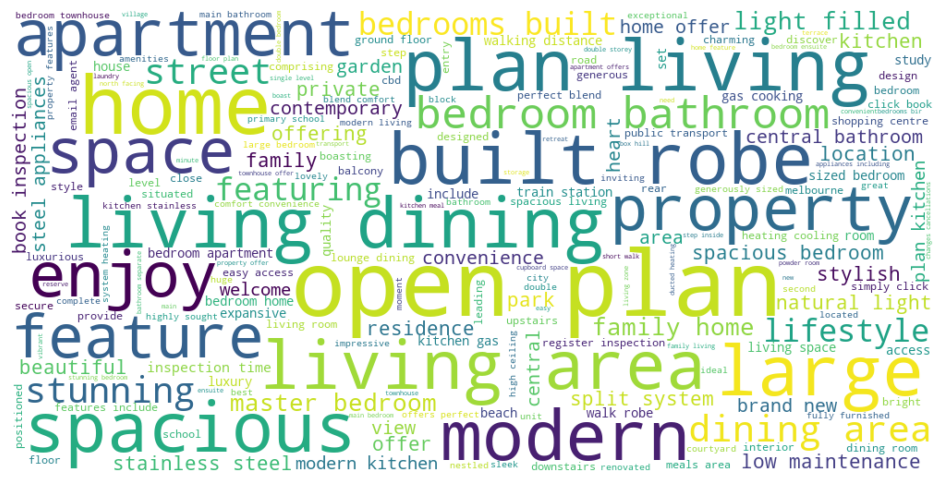

In [68]:
all_words = ' '.join([' '.join(tokens) for tokens in expensive['Cleaned_Tokens']])
wordcloud = WordCloud(
    width=1000, height=500, 
    background_color='white', 
    max_words=200, 
    max_font_size=100, 
).generate(all_words)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') 
plt.show()

In [69]:
cheap = data_cleaned.loc[data_cleaned['Rent_Price'] <= Q3]
cheap.head(5)

URL  Rent_Price  \
0  https://www.domain.com.au/304-373-377-burwood-...       580.0   
1  https://www.domain.com.au/17-brooks-street-faw...       590.0   
2  https://www.domain.com.au/37-genesis-drive-epp...       580.0   
3  https://www.domain.com.au/1-30-park-street-moo...       575.0   
5  https://www.domain.com.au/5a-prouses-road-nort...       430.0   

                                         Address  Bedrooms  Bathrooms Parking  \
0  304/373-377 Burwood Highway, Burwood VIC 3125         2          2       1   
1             17 Brooks Street, Fawkner VIC 3060         4          1       2   
2              37 Genesis Drive, Epping VIC 3076         3          2       1   
3        1/30 Park Street, Moonee Ponds VIC 3039         2          1       2   
5        5a Prouses Road, North Bendigo VIC 3550         3          1       1   

             Property_Type   Latitude   Longitude  \
0  Apartment / Unit / Flat -37.851369  145.129537   
1                    House -37.706151  144.972919   
2                    House -37.622732  144.999599   
3  Apartment / Unit / Flat -37.761711  144.918994   
5                    House -36.742559  144.274647   

               Property_Headline  ...            SA2_NAME21 AREASQKM21  \
0        Convenience and Comfort  ...        Burwood (Vic.)     5.0392   
1              HOME SWEET HOME!!  ...               Fawkner     5.0848   
2        Convenient Family Home!  ...  Epping (Vic.) - West     7.3573   
3           Park Street Prestige  ...          Moonee Ponds     4.3551   
5  Neat and tidy 3 bedroom home!  ...               Bendigo    16.0796   

                                          LOCI_URI21  \
0  http://linked.data.gov.au/dataset/asgsed3/SA2/...   
1  http://linked.data.gov.au/dataset/asgsed3/SA2/...   
2  http://linked.data.gov.au/dataset/asgsed3/SA2/...   
3  http://linked.data.gov.au/dataset/asgsed3/SA2/...   
5  http://linked.data.gov.au/dataset/asgsed3/SA2/...   

                                     suburb_geometry Distance_Bin  \
0  POLYGON ((145.09688 -37.84337, 145.09711 -37.8...     15-20 km   
1  POLYGON ((144.95874 -37.70033, 144.95873 -37.7...     10-15 km   
2  POLYGON ((144.99336 -37.63395, 144.99363 -37.6...     20-30 km   
3  POLYGON ((144.90357 -37.76487, 144.90364 -37.7...      5-10 km   
5  POLYGON ((144.24392 -36.74285, 144.24276 -36.7...          NaN   

   Duration_Bin  Distance_to_Nearest_Station_km   StationDist_Bin  \
0     20-40 min                        3.372020     0.03-50.03 km   
1     20-40 min                        1.742835     0.03-50.03 km   
2     20-40 min                        5.423585     0.03-50.03 km   
3      0-20 min                        0.562879     0.03-50.03 km   
5   120-140 min                      127.253924  100.03-150.03 km   

  CountOfSchool                                     Cleaned_Tokens  
0            31  [extremely, stylish, bedroom, apartment, avail...  
1            11  [welcome, brooks, street, charming, suburb, fa...  
2            17  [apply, click, touch, enquire, link, sent, reg...  
3            37  [book, inspection, online, save, time, view, t...  
5            29  [prd, express, approval, property, property, a...  

[5 rows x 28 columns]

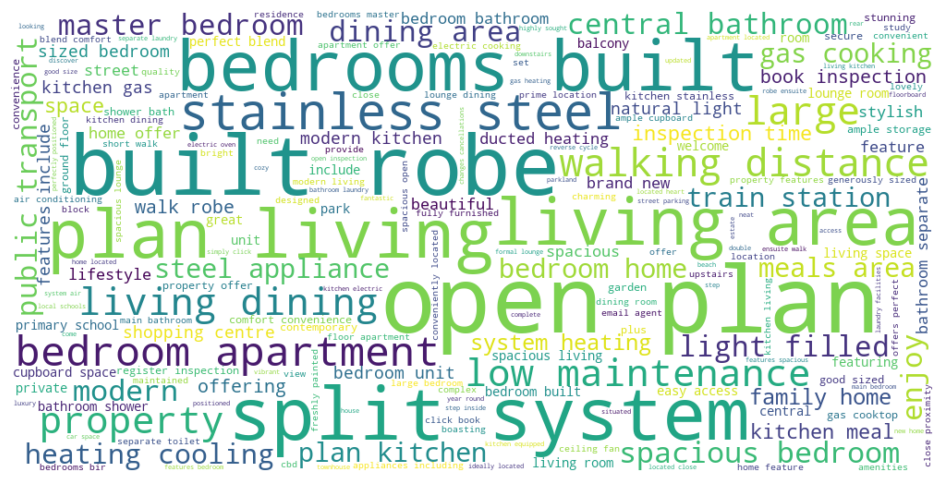

In [70]:
all_cheapwords = ' '.join([' '.join(tokens) for tokens in cheap['Cleaned_Tokens']])
wordcloud = WordCloud(
    width=1000, height=500, 
    background_color='white', 
    max_words=200, 
    max_font_size=100, 
).generate(all_cheapwords)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') 
plt.show()

In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer
data_cleaned['Cleaned_Text'] = data_cleaned['Cleaned_Tokens'].apply(lambda x: ' '.join(x))
tfidf = TfidfVectorizer(max_features=500)

tfidf_matrix = tfidf.fit_transform(data_cleaned['Cleaned_Text'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
print(tfidf_df.head())

   abundance  access  accommodation  additional  adjoining  agent       air  \
0        0.0     0.0            0.0    0.224993        0.0    0.0  0.207908   
1        0.0     0.0            0.0    0.000000        0.0    0.0  0.000000   
2        0.0     0.0            0.0    0.000000        0.0    0.0  0.000000   
3        0.0     0.0            0.0    0.000000        0.0    0.0  0.000000   
4        0.0     0.0            0.0    0.000000        0.0    0.0  0.000000   

   airy  alfresco  amenities  ...   welcome  welcoming  west  windows  wir  \
0   0.0       0.0        0.0  ...  0.000000        0.0   0.0      0.0  0.0   
1   0.0       0.0        0.0  ...  0.171687        0.0   0.0      0.0  0.0   
2   0.0       0.0        0.0  ...  0.000000        0.0   0.0      0.0  0.0   
3   0.0       0.0        0.0  ...  0.000000        0.0   0.0      0.0  0.0   
4   0.0       0.0        0.0  ...  0.000000        0.0   0.0      0.0  0.0   

   wonderful  yard  yarra  year  zone  
0        0.0   0

In [72]:
from textblob import TextBlob

def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity
data_cleaned['Sentiment'] = data_cleaned['Cleaned_Text'].apply(get_sentiment)

print(data_cleaned[['Property_Description', 'Sentiment']].head())

                                Property_Description  Sentiment
0  This extremely stylish two-bedroom apartment i...   0.240741
1  Welcome to 17 Brooks Street in the charming su...   0.535000
2  TO APPLY: please click "Get in touch" or "Enqu...   0.377778
3  ** BOOK INSPECTION ONLINE OR SAVE TIME VIEW OU...   0.535000
4  This stunning beachside double-story residence...   0.246032


In [73]:
px.scatter(data_cleaned, x= 'Sentiment', y = "Rent_Price")

In [74]:
correlation_sent = data_cleaned['Sentiment'].corr(data_cleaned['Rent_Price'])
print(correlation_sent)

0.13313575638049682


### LDA for headline

In [75]:
data_cleaned['Property_Headline'] = data_cleaned['Property_Headline'].astype(str)
data_cleaned['Cleaned_HLTokens'] = data_cleaned['Property_Headline'].apply(clean_and_tokenize_spacy)

Convenience and Comfort
HOME SWEET HOME!!
Convenient Family Home!
Park Street Prestige
Location, location, location!
Neat and tidy 3 bedroom home!
A polished gem with exceptional convenience
Modern 3-Bedroom Unit with Private Backyard
Sophistication, functionality and luxury
PLEASE CLICK THE BELOW 'REQUEST AN INSPECTION' BUTTON TO REGISTER FOR THE NEXT AVAILABLE INSPECTION
Renovated Home Walk To Everythings
4 Bedroom Home
GADSDEN TWO-BEDROOM APARTMENT - UNFURNISHED
Ticks All The Boxes
TRANQUIL FAMILY HOME
Love The Location, Courtyard Living Plus Study
Embrace effortless living: Simplify your life with low maintenance homes
3 Bedroom family home in perfect location
Perfect Family Home in Belmont!
Purpose Built Student Only Accommodation.
Waterfront Precinct - Fully Renovated Three Bedroom, Two Bathroom Home
MODERN THREE BEDROOM TOWNHOUSE
RENOVATED CREAM BRICK IN FLORA HILL
Charming Unit!
Large 2 Bedroom Apartment
4 Bedroom Stylish And Modern Townhouse
2 Bedroom Apartment In Heart of the

In [76]:
from gensim import corpora
from gensim.models.ldamodel import LdaModel

dictionary = corpora.Dictionary(data_cleaned['Cleaned_HLTokens'])
corpus = [dictionary.doc2bow(text) for text in data_cleaned['Cleaned_HLTokens']]

lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10)

topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.063*"new" + 0.054*"townhouse" + 0.040*"brand" + 0.031*"bedroom" + 0.024*"inspection"')
(1, '0.077*"modern" + 0.069*"apartment" + 0.063*"spacious" + 0.058*"bedroom" + 0.057*"living"')
(2, '0.054*"furnished" + 0.045*"fully" + 0.044*"apartment" + 0.034*"bedroom" + 0.026*"views"')
(3, '0.168*"home" + 0.101*"location" + 0.092*"family" + 0.064*"bedroom" + 0.027*"great"')
(4, '0.076*"unit" + 0.065*"bedroom" + 0.032*"heart" + 0.024*"light" + 0.021*"spacious"')


In [77]:
data_cleaned

URL  Rent_Price  \
0     https://www.domain.com.au/304-373-377-burwood-...       580.0   
1     https://www.domain.com.au/17-brooks-street-faw...       590.0   
2     https://www.domain.com.au/37-genesis-drive-epp...       580.0   
3     https://www.domain.com.au/1-30-park-street-moo...       575.0   
4     https://www.domain.com.au/343-dromana-parade-s...       850.0   
...                                                 ...         ...   
5519  https://www.domain.com.au/8-o-farrell-place-ge...       550.0   
5520  https://www.domain.com.au/2-32-acheron-avenue-...       450.0   
5521  https://www.domain.com.au/1105-20-wardens-walk...       500.0   
5522  https://www.domain.com.au/4a-brian-street-fawk...       500.0   
5523  https://www.domain.com.au/12-frew-avenue-frank...       495.0   

                                            Address  Bedrooms  Bathrooms  \
0     304/373-377 Burwood Highway, Burwood VIC 3125         2          2   
1                17 Brooks Street, Fawkner VIC 3060         4          1   
2                 37 Genesis Drive, Epping VIC 3076         3          2   
3           1/30 Park Street, Moonee Ponds VIC 3039         2          1   
4         343 Dromana Parade, Safety Beach VIC 3936         4          3   
...                                             ...       ...        ...   
5519            8 O'Farrell Place, Geelong VIC 3220         2          1   
5520        2/32 Acheron Avenue, Reservoir VIC 3073         2          1   
5521          1105/20 Wardens Walk, Coburg VIC 3058         1          1   
5522              4A Brian Street, Fawkner VIC 3060         2          1   
5523             12 Frew Avenue, Frankston VIC 3199         3          1   

     Parking            Property_Type   Latitude   Longitude  \
0          1  Apartment / Unit / Flat -37.851369  145.129537   
1          2                    House -37.706151  144.972919   
2          1                    House -37.622732  144.999599   
3          2  Apartment / Unit / Flat -37.761711  144.918994   
4          2                    House -38.308161  144.995930   
...      ...                      ...        ...         ...   
5519       2  Apartment / Unit / Flat -38.149266  144.357552   
5520       1  Apartment / Unit / Flat -37.721180  145.017696   
5521       1  Apartment / Unit / Flat -37.738572  144.968578   
5522       2  Apartment / Unit / Flat -37.694474  144.967703   
5523       3                    House -38.137874  145.148351   

                                      Property_Headline  ...  \
0                               Convenience and Comfort  ...   
1                                     HOME SWEET HOME!!  ...   
2                               Convenient Family Home!  ...   
3                                  Park Street Prestige  ...   
4                         Location, location, location!  ...   
...                                                 ...  ...   
5519  Architecturally designed apartment in the hear...  ...   
5520                                     Great Location  ...   
5521  1 WEEKS FREE RENT - BRAND NEW 1 BEDROOM APARTMENT  ...   
5522               SIMPLY CHARMING LOW MAINTENANCE UNIT  ...   
5523  Beautifully Renovated Home in Family Friendly ...  ...   

                                        suburb_geometry Distance_Bin  \
0     POLYGON ((145.09688 -37.84337, 145.09711 -37.8...     15-20 km   
1     POLYGON ((144.95874 -37.70033, 144.95873 -37.7...     10-15 km   
2     POLYGON ((144.99336 -37.63395, 144.99363 -37.6...     20-30 km   
3     POLYGON ((144.90357 -37.76487, 144.90364 -37.7...      5-10 km   
4     POLYGON ((144.99146 -38.31296, 144.99178 -38.3...       50+ km   
...                                                 ...          ...   
5519  POLYGON ((144.35324 -38.14495, 144.35335 -38.1...       50+ km   
5520  POLYGON ((145.00701 -37.72072, 145.00715 -37.7...     10-15 km   
5521  POLYGON ((144.96328 -37.74286, 144.96351 -37.7...      5-10 km   
5522  POLYGON ((144.95874 -3

In [78]:
topic_labels = {
    0: "Family Homes in Prime Locations",
    1: "Beautiful, Convenient Family Homes",
    2: "Modern, Low-Maintenance Apartments",
    3: "Stunning Furnished Apartments/Townhouses",
    4: "Central Units for Lease"
}

data_cleaned['Dominant_Topic'] = [max(lda_model[corpus[i]], key=lambda x: x[1])[0] for i in range(len(corpus))]

data_cleaned['Dominant_Topic_Label'] = data_cleaned['Dominant_Topic'].map(topic_labels)

print(data_cleaned[['Property_Headline', 'Dominant_Topic_Label']].head())

               Property_Headline                      Dominant_Topic_Label
0        Convenience and Comfort           Family Homes in Prime Locations
1              HOME SWEET HOME!!  Stunning Furnished Apartments/Townhouses
2        Convenient Family Home!  Stunning Furnished Apartments/Townhouses
3           Park Street Prestige        Modern, Low-Maintenance Apartments
4  Location, location, location!  Stunning Furnished Apartments/Townhouses


In [79]:
data_cleaned

URL  Rent_Price  \
0     https://www.domain.com.au/304-373-377-burwood-...       580.0   
1     https://www.domain.com.au/17-brooks-street-faw...       590.0   
2     https://www.domain.com.au/37-genesis-drive-epp...       580.0   
3     https://www.domain.com.au/1-30-park-street-moo...       575.0   
4     https://www.domain.com.au/343-dromana-parade-s...       850.0   
...                                                 ...         ...   
5519  https://www.domain.com.au/8-o-farrell-place-ge...       550.0   
5520  https://www.domain.com.au/2-32-acheron-avenue-...       450.0   
5521  https://www.domain.com.au/1105-20-wardens-walk...       500.0   
5522  https://www.domain.com.au/4a-brian-street-fawk...       500.0   
5523  https://www.domain.com.au/12-frew-avenue-frank...       495.0   

                                            Address  Bedrooms  Bathrooms  \
0     304/373-377 Burwood Highway, Burwood VIC 3125         2          2   
1                17 Brooks Street, Fawkner VIC 3060         4          1   
2                 37 Genesis Drive, Epping VIC 3076         3          2   
3           1/30 Park Street, Moonee Ponds VIC 3039         2          1   
4         343 Dromana Parade, Safety Beach VIC 3936         4          3   
...                                             ...       ...        ...   
5519            8 O'Farrell Place, Geelong VIC 3220         2          1   
5520        2/32 Acheron Avenue, Reservoir VIC 3073         2          1   
5521          1105/20 Wardens Walk, Coburg VIC 3058         1          1   
5522              4A Brian Street, Fawkner VIC 3060         2          1   
5523             12 Frew Avenue, Frankston VIC 3199         3          1   

     Parking            Property_Type   Latitude   Longitude  \
0          1  Apartment / Unit / Flat -37.851369  145.129537   
1          2                    House -37.706151  144.972919   
2          1                    House -37.622732  144.999599   
3          2  Apartment / Unit / Flat -37.761711  144.918994   
4          2                    House -38.308161  144.995930   
...      ...                      ...        ...         ...   
5519       2  Apartment / Unit / Flat -38.149266  144.357552   
5520       1  Apartment / Unit / Flat -37.721180  145.017696   
5521       1  Apartment / Unit / Flat -37.738572  144.968578   
5522       2  Apartment / Unit / Flat -37.694474  144.967703   
5523       3                    House -38.137874  145.148351   

                                      Property_Headline  ... Duration_Bin  \
0                               Convenience and Comfort  ...    20-40 min   
1                                     HOME SWEET HOME!!  ...    20-40 min   
2                               Convenient Family Home!  ...    20-40 min   
3                                  Park Street Prestige  ...     0-20 min   
4                         Location, location, location!  ...    60-80 min   
...                                                 ...  ...          ...   
5519  Architecturally designed apartment in the hear...  ...    60-80 min   
5520                                     Great Location  ...    20-40 min   
5521  1 WEEKS FREE RENT - BRAND NEW 1 BEDROOM APARTMENT  ...     0-20 min   
5522               SIMPLY CHARMING LOW MAINTENANCE UNIT  ...    20-40 min   
5523  Beautifully Renovated Home in Family Friendly ...  ...    40-60 min   

     Distance_to_Nearest_Station_km StationDist_Bin CountOfSchool  \
0                          3.372020   0.03-50.03 km            31   
1                          1.742835   0.03-50.03 km            11   
2                          5.423585   0.03-50.03 km            17   
3                          0.562879   0.03-50.03 km            37   
4                         20.690771   0.03-50.03 km            16   
...                             ...             ...           ...   
5519                      48.876688   0.03-50.03 km            34   
5520                       1.335725   0.

In [80]:
topic_distribution = data_cleaned['Dominant_Topic_Label'].value_counts().reset_index()
topic_distribution.columns = ['Topic', 'Count']
fig = px.bar(topic_distribution, x='Topic', y='Count', title="Topic Distribution")
fig.show()


In [81]:
anova_result = stats.f_oneway(*[group['Rent_Price'].values for name, group in data_cleaned.groupby('Dominant_Topic_Label')])
print(f'ANOVA F-statistic: {anova_result.statistic}, p-value: {anova_result.pvalue}')

ANOVA F-statistic: 7.709657859375936, p-value: 3.4292478988626307e-06


In [82]:
data_cleaned

URL  Rent_Price  \
0     https://www.domain.com.au/304-373-377-burwood-...       580.0   
1     https://www.domain.com.au/17-brooks-street-faw...       590.0   
2     https://www.domain.com.au/37-genesis-drive-epp...       580.0   
3     https://www.domain.com.au/1-30-park-street-moo...       575.0   
4     https://www.domain.com.au/343-dromana-parade-s...       850.0   
...                                                 ...         ...   
5519  https://www.domain.com.au/8-o-farrell-place-ge...       550.0   
5520  https://www.domain.com.au/2-32-acheron-avenue-...       450.0   
5521  https://www.domain.com.au/1105-20-wardens-walk...       500.0   
5522  https://www.domain.com.au/4a-brian-street-fawk...       500.0   
5523  https://www.domain.com.au/12-frew-avenue-frank...       495.0   

                                            Address  Bedrooms  Bathrooms  \
0     304/373-377 Burwood Highway, Burwood VIC 3125         2          2   
1                17 Brooks Street, Fawkner VIC 3060         4          1   
2                 37 Genesis Drive, Epping VIC 3076         3          2   
3           1/30 Park Street, Moonee Ponds VIC 3039         2          1   
4         343 Dromana Parade, Safety Beach VIC 3936         4          3   
...                                             ...       ...        ...   
5519            8 O'Farrell Place, Geelong VIC 3220         2          1   
5520        2/32 Acheron Avenue, Reservoir VIC 3073         2          1   
5521          1105/20 Wardens Walk, Coburg VIC 3058         1          1   
5522              4A Brian Street, Fawkner VIC 3060         2          1   
5523             12 Frew Avenue, Frankston VIC 3199         3          1   

     Parking            Property_Type   Latitude   Longitude  \
0          1  Apartment / Unit / Flat -37.851369  145.129537   
1          2                    House -37.706151  144.972919   
2          1                    House -37.622732  144.999599   
3          2  Apartment / Unit / Flat -37.761711  144.918994   
4          2                    House -38.308161  144.995930   
...      ...                      ...        ...         ...   
5519       2  Apartment / Unit / Flat -38.149266  144.357552   
5520       1  Apartment / Unit / Flat -37.721180  145.017696   
5521       1  Apartment / Unit / Flat -37.738572  144.968578   
5522       2  Apartment / Unit / Flat -37.694474  144.967703   
5523       3                    House -38.137874  145.148351   

                                      Property_Headline  ... Duration_Bin  \
0                               Convenience and Comfort  ...    20-40 min   
1                                     HOME SWEET HOME!!  ...    20-40 min   
2                               Convenient Family Home!  ...    20-40 min   
3                                  Park Street Prestige  ...     0-20 min   
4                         Location, location, location!  ...    60-80 min   
...                                                 ...  ...          ...   
5519  Architecturally designed apartment in the hear...  ...    60-80 min   
5520                                     Great Location  ...    20-40 min   
5521  1 WEEKS FREE RENT - BRAND NEW 1 BEDROOM APARTMENT  ...     0-20 min   
5522               SIMPLY CHARMING LOW MAINTENANCE UNIT  ...    20-40 min   
5523  Beautifully Renovated Home in Family Friendly ...  ...    40-60 min   

     Distance_to_Nearest_Station_km StationDist_Bin CountOfSchool  \
0                          3.372020   0.03-50.03 km            31   
1                          1.742835   0.03-50.03 km            11   
2                          5.423585   0.03-50.03 km            17   
3                          0.562879   0.03-50.03 km            37   
4                         20.690771   0.03-50.03 km            16   
...                             ...             ...           ...   
5519                      48.876688   0.03-50.03 km            34   
5520                       1.335725   0.

### BERT (desc)

In [83]:
# BERT_categorised = pd.read_csv("../data/curated/categorised.csv").drop(["Unnamed: 0", "Unnamed: 0.1"], axis=1)
# BERT_categorised
# des_cat = BERT_categorised.groupby('Category')['Rent_Price'].mean().reset_index()
# fig = px.bar(des_cat, x="Category", y="Rent_Price", 
#              title="Average Rent Price by Distance to Descriptions Category",
#              labels={'Rent_Price': 'Average Rent Price ($)', 'StationDist_Bin': 'Descriptions Category'})

# fig.show()
# anova_result = stats.f_oneway(*[group['Rent_Price'].values for name, group in BERT_categorised.groupby('Category')])
# print(f'ANOVA F-statistic: {anova_result.statistic}, p-value: {anova_result.pvalue}')

In [84]:
import torch
from transformers import AutoTokenizer, BertForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("textattack/bert-base-uncased-yelp-polarity")
model = BertForSequenceClassification.from_pretrained(
    "textattack/bert-base-uncased-yelp-polarity", problem_type="multi_label_classification"
)

descriptions = data_cleaned['Cleaned_Text']
model.eval()

num_labels = len(model.config.id2label)
model.config.num_labels = num_labels

losses = []
predicitons =[]
labels_all = []
for desc in descriptions:
    inputs = tokenizer(desc, return_tensors="pt", truncation=True, padding=True)

    with torch.no_grad():
        logits = model(**inputs).logits
    predicted_class_ids = torch.arange(0, logits.shape[-1])[torch.sigmoid(logits).squeeze(dim=0) > 0.5]

    labels = torch.sum(
        torch.nn.functional.one_hot(predicted_class_ids[None, :].clone(), num_classes=num_labels), dim=1
    ).to(torch.float)

    model.train()


    loss = model(**inputs, labels=labels).loss

    losses.append(loss.item())
    labels_all.append(labels)
    predicitons.append(predicted_class_ids)

mean_loss = sum(losses) / len(losses)

print(f"Mean Loss: {mean_loss}")

predicitons
type(labels_all)
flattened_predictions = [tensor.flatten().tolist() for tensor in labels_all]

predictions_df = pd.DataFrame(flattened_predictions, columns=["negative_class", "positive_class"])

data_cleaned = pd.concat([data_cleaned, predictions_df], axis=1)
data_cleaned

/Users/tinas/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884



Mean Loss: 0.08415998549050208


URL  Rent_Price  \
0     https://www.domain.com.au/304-373-377-burwood-...       580.0   
1     https://www.domain.com.au/17-brooks-street-faw...       590.0   
2     https://www.domain.com.au/37-genesis-drive-epp...       580.0   
3     https://www.domain.com.au/1-30-park-street-moo...       575.0   
4     https://www.domain.com.au/343-dromana-parade-s...       850.0   
...                                                 ...         ...   
5519  https://www.domain.com.au/8-o-farrell-place-ge...       550.0   
5520  https://www.domain.com.au/2-32-acheron-avenue-...       450.0   
5521  https://www.domain.com.au/1105-20-wardens-walk...       500.0   
5522  https://www.domain.com.au/4a-brian-street-fawk...       500.0   
5523  https://www.domain.com.au/12-frew-avenue-frank...       495.0   

                                            Address  Bedrooms  Bathrooms  \
0     304/373-377 Burwood Highway, Burwood VIC 3125         2          2   
1                17 Brooks Street, Fawkner VIC 3060         4          1   
2                 37 Genesis Drive, Epping VIC 3076         3          2   
3           1/30 Park Street, Moonee Ponds VIC 3039         2          1   
4         343 Dromana Parade, Safety Beach VIC 3936         4          3   
...                                             ...       ...        ...   
5519            8 O'Farrell Place, Geelong VIC 3220         2          1   
5520        2/32 Acheron Avenue, Reservoir VIC 3073         2          1   
5521          1105/20 Wardens Walk, Coburg VIC 3058         1          1   
5522              4A Brian Street, Fawkner VIC 3060         2          1   
5523             12 Frew Avenue, Frankston VIC 3199         3          1   

     Parking            Property_Type   Latitude   Longitude  \
0          1  Apartment / Unit / Flat -37.851369  145.129537   
1          2                    House -37.706151  144.972919   
2          1                    House -37.622732  144.999599   
3          2  Apartment / Unit / Flat -37.761711  144.918994   
4          2                    House -38.308161  144.995930   
...      ...                      ...        ...         ...   
5519       2  Apartment / Unit / Flat -38.149266  144.357552   
5520       1  Apartment / Unit / Flat -37.721180  145.017696   
5521       1  Apartment / Unit / Flat -37.738572  144.968578   
5522       2  Apartment / Unit / Flat -37.694474  144.967703   
5523       3                    House -38.137874  145.148351   

                                      Property_Headline  ... StationDist_Bin  \
0                               Convenience and Comfort  ...   0.03-50.03 km   
1                                     HOME SWEET HOME!!  ...   0.03-50.03 km   
2                               Convenient Family Home!  ...   0.03-50.03 km   
3                                  Park Street Prestige  ...   0.03-50.03 km   
4                         Location, location, location!  ...   0.03-50.03 km   
...                                                 ...  ...             ...   
5519  Architecturally designed apartment in the hear...  ...   0.03-50.03 km   
5520                                     Great Location  ...   0.03-50.03 km   
5521  1 WEEKS FREE RENT - BRAND NEW 1 BEDROOM APARTMENT  ...   0.03-50.03 km   
5522               SIMPLY CHARMING LOW MAINTENANCE UNIT  ...   0.03-50.03 km   
5523  Beautifully Renovated Home in Family Friendly ...  ...   0.03-50.03 km   

     CountOfSchool                                     Cleaned_Tokens  \
0               31  [extremely, stylish, bedroom, apartment, avail...   
1               11  [welcome, brooks, street, charming, suburb, fa...   
2               17  [apply, click, touch, enquire, link, sent, reg...   
3               37  [book, inspection, online, save, time, view, t...   
4               16  [stunning, beachside, double, story, residence...   
...            ...                                                ...   
5519            34  [impeccably, located, sec

In [85]:
predictions_df

negative_class  positive_class
0                0.0             1.0
1                0.0             1.0
2                0.0             1.0
3                0.0             1.0
4                0.0             1.0
...              ...             ...
5519             0.0             1.0
5520             0.0             1.0
5521             0.0             1.0
5522             0.0             1.0
5523             0.0             1.0

[5524 rows x 2 columns]

In [86]:
input_df = data_cleaned.copy()
input_df

URL  Rent_Price  \
0     https://www.domain.com.au/304-373-377-burwood-...       580.0   
1     https://www.domain.com.au/17-brooks-street-faw...       590.0   
2     https://www.domain.com.au/37-genesis-drive-epp...       580.0   
3     https://www.domain.com.au/1-30-park-street-moo...       575.0   
4     https://www.domain.com.au/343-dromana-parade-s...       850.0   
...                                                 ...         ...   
5519  https://www.domain.com.au/8-o-farrell-place-ge...       550.0   
5520  https://www.domain.com.au/2-32-acheron-avenue-...       450.0   
5521  https://www.domain.com.au/1105-20-wardens-walk...       500.0   
5522  https://www.domain.com.au/4a-brian-street-fawk...       500.0   
5523  https://www.domain.com.au/12-frew-avenue-frank...       495.0   

                                            Address  Bedrooms  Bathrooms  \
0     304/373-377 Burwood Highway, Burwood VIC 3125         2          2   
1                17 Brooks Street, Fawkner VIC 3060         4          1   
2                 37 Genesis Drive, Epping VIC 3076         3          2   
3           1/30 Park Street, Moonee Ponds VIC 3039         2          1   
4         343 Dromana Parade, Safety Beach VIC 3936         4          3   
...                                             ...       ...        ...   
5519            8 O'Farrell Place, Geelong VIC 3220         2          1   
5520        2/32 Acheron Avenue, Reservoir VIC 3073         2          1   
5521          1105/20 Wardens Walk, Coburg VIC 3058         1          1   
5522              4A Brian Street, Fawkner VIC 3060         2          1   
5523             12 Frew Avenue, Frankston VIC 3199         3          1   

     Parking            Property_Type   Latitude   Longitude  \
0          1  Apartment / Unit / Flat -37.851369  145.129537   
1          2                    House -37.706151  144.972919   
2          1                    House -37.622732  144.999599   
3          2  Apartment / Unit / Flat -37.761711  144.918994   
4          2                    House -38.308161  144.995930   
...      ...                      ...        ...         ...   
5519       2  Apartment / Unit / Flat -38.149266  144.357552   
5520       1  Apartment / Unit / Flat -37.721180  145.017696   
5521       1  Apartment / Unit / Flat -37.738572  144.968578   
5522       2  Apartment / Unit / Flat -37.694474  144.967703   
5523       3                    House -38.137874  145.148351   

                                      Property_Headline  ... StationDist_Bin  \
0                               Convenience and Comfort  ...   0.03-50.03 km   
1                                     HOME SWEET HOME!!  ...   0.03-50.03 km   
2                               Convenient Family Home!  ...   0.03-50.03 km   
3                                  Park Street Prestige  ...   0.03-50.03 km   
4                         Location, location, location!  ...   0.03-50.03 km   
...                                                 ...  ...             ...   
5519  Architecturally designed apartment in the hear...  ...   0.03-50.03 km   
5520                                     Great Location  ...   0.03-50.03 km   
5521  1 WEEKS FREE RENT - BRAND NEW 1 BEDROOM APARTMENT  ...   0.03-50.03 km   
5522               SIMPLY CHARMING LOW MAINTENANCE UNIT  ...   0.03-50.03 km   
5523  Beautifully Renovated Home in Family Friendly ...  ...   0.03-50.03 km   

     CountOfSchool                                     Cleaned_Tokens  \
0               31  [extremely, stylish, bedroom, apartment, avail...   
1               11  [welcome, brooks, street, charming, suburb, fa...   
2               17  [apply, click, touch, enquire, link, sent, reg...   
3               37  [book, inspection, online, save, time, view, t...   
4               16  [stunning, beachside, double, story, residence...   
...            ...                                                ...   
5519            34  [impeccably, located, sec

In [87]:
input_df.columns

Index(['URL', 'Rent_Price', 'Address', 'Bedrooms', 'Bathrooms', 'Parking',
       'Property_Type', 'Latitude', 'Longitude', 'Property_Headline',
       'Property_Description', 'Street', 'Suburb', 'Postcode', 'geometry',
       'Duration_to_CBD_min', 'Distances_to_CBD_km', 'SA2_CODE21',
       'SA2_NAME21', 'AREASQKM21', 'LOCI_URI21', 'suburb_geometry',
       'Distance_Bin', 'Duration_Bin', 'Distance_to_Nearest_Station_km',
       'StationDist_Bin', 'CountOfSchool', 'Cleaned_Tokens', 'Cleaned_Text',
       'Sentiment', 'Cleaned_HLTokens', 'Dominant_Topic',
       'Dominant_Topic_Label', 'negative_class', 'positive_class'],
      dtype='object')

In [88]:
input_df = input_df[[ 'Rent_Price', 'Bedrooms', 'Bathrooms', 'Parking','Property_Type', 'Street', 'Suburb', 'Postcode', 'Distance_to_Nearest_Station_km', 'CountOfSchool',  'Cleaned_Text',
       'Sentiment','Cleaned_HLTokens', 'Dominant_Topic','Dominant_Topic_Label', 'negative_class', 'positive_class']]

In [90]:
input_df.to_csv("../data/curated/input_df.csv", index=False)